# Exploring raw Ca transients obtained from neurons
#### Marco Arieli Herrera-Valdez
#### Facultad de Ciencias, UNAM
##### Last revised 2016.01.21




In [ ]:
from transientPreAnalysis import *

In [1]:
import scipy as sc
import matplotlib.pylab as gr
import pickle 
import string as st
%matplotlib inline
sc.test('all')

# Calculate a cumulative distribution function from a sample, using a specified set of bins. 
def calcCDF(sample,graph=0):
    """Example:
    Calculate a cumulative distribution function from a sample, using a specified set of bins. 
    sSize= 100
    mySample=sc.randn(sSize)
    Cdf = calcCDF(bins=myBins, sample=mySample)
    """
    mySample=sc.copy(sample)
    mySample.sort()
    bins= sc.unique(mySample)
    nBins = len(bins)
    sSize= sc.float32(len(mySample))
    #print(bins,nBins)
    #print(mySample,sSize)
    cdf = sc.zeros(nBins)
    for n in sc.arange(nBins):
        A= sc.where(mySample<bins[n])[0]
        cdf[n]=len(A)/sSize
    #print(cdf,cdf.sum())
    f = sc.vectorize(lambda x : sc.interp(x, bins,cdf))
    fInverse = sc.vectorize(lambda y: sc.interp(y,cdf,bins))
    if graph:
        gr.figure()
        gr.plot(bins,cdf,'wo')
        #gr.plot(sample[30:-20],f(sample[30:-20]),'.')
    return f,fInverse


def calcThresholdFromCDF(cdfInverse, quant=0.95):
    """
    Calculate thresholds using the inverse of the cumulative distribution function given a list of quants. 
    """
    alphaX= cdfInverse(quant)
    return alphaX

def calcThresholdsFromCDF(cdfInverse, quants=(0.95,)):
    """
    Calculate thresholds using the inverse of the cumulative distribution function given a list of quants. 
    """
    if len(quants)>1:
        nValues = len(quants)
        alphaX=sc.zeros(nValues)
        for n in sc.arange(nValues):
            alphaX[n]= cdfInverse(quants[n])
    else: 
        print('calcThresholdsFromCDF needs more than one quantile to work')
    return alphaX


def calcISICDF(train):
    y= calculateISIs(train)
    f,fInverse=calcCDF(y,graph=0)
    return f,fInverse


def fMinNorm(dataArray):
    """
    Nomalization of a time series by taking the minimum as a baseline. 
    Example:
    fmd = fMinNorm(dataArray)     
    where dataArray is a one-dimensional time series.  
    """
    fMinData=sc.zeros(dataArray.shape,'float64')
    for n in sc.arange(nCells):
        fMin= dataArray[n].min()
        fMinData[n]= (dataArray[n] - fMin)/(fMin)
    return fMinData

def fMaxMinNorm(dataArray):
    """
    Nomalization of a time series by taking the minimum as a baseline. 
    Example:
    fmd = fMinNorm(dataArray)     
    where dataArray is a one-dimensional time series.  
    """
    fMinData=sc.zeros(dataArray.shape,'float64')
    for n in sc.arange(nCells):
        fMin= dataArray[n].min()
        fMax= dataArray[n].max()
        fMinData[n]= (dataArray[n] - fMin)/(fMax-fMin)
    return fMinData



def extractPXPData(fName):
    """
    extractPXPData
    Example:
    allData=extractPXPData("microcircuitsNetworks/cort76dp1c.pxp")
    """
    allData=igor.load(fName)
    # Dictionary containing the names of recorded variables during the experiment
    dataNames= st.split(allData.children[0].userstr["S_waveNames"], ";")
    extractedData1=list()
    extractedData2=list()

    for nam in dataNames:
        if len(nam)>3:
            myInd=sc.int32(nam[4:]) -1
            str2= "w2=allData." + nam + ".data"%(myInd)
            exec(str2)
            extractedData2.append(w2)
        else:
            print("Found empty string")

    rawData=sc.array(extractedData2)
    return rawData



Running unit tests for scipy
NumPy version 1.8.0rc1

/System/Library/Frameworks/Python.framework/Versions/2.7/Extras/lib/python/numpy/lib/utils.py:134: DeprecationWarning: `scipy.lib.blas` is deprecated, use `scipy.linalg.blas` instead!
  warnings.warn(depdoc, DeprecationWarning)
/System/Library/Frameworks/Python.framework/Versions/2.7/Extras/lib/python/numpy/lib/utils.py:134: DeprecationWarning: `scipy.lib.lapack` is deprecated, use `scipy.linalg.lapack` instead!
  warnings.warn(depdoc, DeprecationWarning)
.


NumPy is installed in /System/Library/Frameworks/Python.framework/Versions/2.7/Extras/lib/python/numpy
SciPy version 0.13.0b1
SciPy is installed in /System/Library/Frameworks/Python.framework/Versions/2.7/Extras/lib/python/scipy
Python version 2.7.10 (v2.7.10:15c95b7d81dc, May 23 2015, 09:33:12) [GCC 4.2.1 (Apple Inc. build 5666) (dot 3)]
nose version 1.3.7



----------------------------------------------------------------------
Ran 1 test in 3.487s

OK


Now let us explore the data

In [5]:
# Extraction of one data set
fName="./data/cort76dp1c.pkl"
pkl_file = open(fName, 'rb')
rawData=pickle.load(pkl_file)
print(rawData)
nCells,nFrames= rawData.shape
#frameMS=300.00


[[ 481.19   483.19   475.143 ...,  509.286  502.238  502.143]
 [ 435.476  438.381  436.19  ...,  434.238  426.857  436.429]
 [ 439.238  441.762  438.381 ...,  472.19   472.905  471.81 ]
 ..., 
 [ 698.714  692.857  687.857 ...,  666.524  657.524  656.286]
 [ 662.381  675.286  670.    ...,  674.048  683.476  688.095]
 [ 585.143  584.095  579.19  ...,  581.238  578.524  586.381]]


In [7]:
# Normalize the Ca-transients
# Envelope
maxMinF=rawData.max(0)- rawData.min(0)
print(maxMinF[0],maxMinF[-1])
avgF=rawData.mean(0)
print(avgF[0],avgF[-1])
# Normalization by fMin
fMinData= fMinNorm(rawData)
fMaxMinData= fMaxMinNorm(rawData)
print(fMaxMinData)


(497.33299999999997, 503.666)
(633.77120909090911, 626.14605757575794)
[[ 0.08015993  0.09769656  0.02713793 ...,  0.32651451  0.26471542
   0.26388243]
 [ 0.24260088  0.27541684  0.25066649 ...,  0.22861597  0.14523745
   0.25336632]
 [ 0.06381642  0.11666178  0.04587329 ...,  0.75373728  0.76870734
   0.74578116]
 ..., 
 [ 0.63003291  0.56311412  0.50598693 ...,  0.26224807  0.15941913
   0.14527444]
 [ 0.          0.14874023  0.08781494 ...,  0.13447131  0.2431364
   0.29637399]
 [ 0.34171458  0.32994565  0.274863   ...,  0.29786183  0.26738388
   0.3556172 ]]


Area under the calcim traces and normalization 

In [26]:
# Calculation for the areas under the curves of the Ca-Transients
# Keep only the last element of the cumulative sum over time to get the total activity and normalize
areas=fMaxMinData.cumsum(1)[:,-1]
normAreas= areas/areas.max()
print("Areas",areas)
print("Normalized areas",normAreas)
cdfArea,cdfInvArea= calcCDF(normAreas)
signif=sc.arange(0.90,0.96,0.05)
# Uncomment this line if more than one threshold is used
threshArea= calcThresholdsFromCDF(cdfInvArea, quants=signif)
#threshArea= calcThresholdFromCDF(cdfInvArea, signif[0])
areaArray= sc.arange(0,1,0.01)
sortedAreas= sc.sort(normAreas)
nThresh=len(threshArea)
cellsSignif=list()
cellsNoSignif=list()
for m in sc.arange(nThresh):
    cellsSignif.append(sc.where(normAreas>threshArea[m])[0])
    cellsNoSignif.append(sc.where(normAreas<=threshArea[m])[0])
    print(cellsSignif[m])

bins= sc.arange(0, 1, 1/20.0)
counts, binEdges= sc.histogram(normAreas,bins)




('Areas', array([ 335.0815541 ,  324.64981248,  357.18491688,  278.67707793,
        432.08889707,  488.69853783,  515.38459902,  296.85049233,
        394.83224608,  261.8511451 ,  381.06009101,  428.58221687,
        356.30071083,  377.96362862,  223.43177783,  252.68273156,
        300.67038002,  528.39800779,  421.45436535,  371.59114663,
        494.40367923,  422.56716693,  462.29457719,  467.91521378,
        271.86011273,  569.33056367,  438.37509739,  394.09576945,
        488.49885199,  359.46309388,  365.97049015,  595.66017847,
        323.1679    ,  393.74896202,  476.02648955,  350.23089156,
        326.75665922,  427.23975758,  265.00534605,  373.0504755 ,
        362.78153156,  402.10063902,  360.16157238,  298.82820756,
        464.96475556,  359.58697239,  357.380544  ,  355.15534098,
        243.00641249,  203.49510005,  318.97540251,  432.09531508,
        403.2589454 ,  349.91099029,  317.26774074,  312.82319143,
        415.40210588,  448.546269  ,  391.92771331, 

Graph the traces with significatively high areas with threshold 0.95

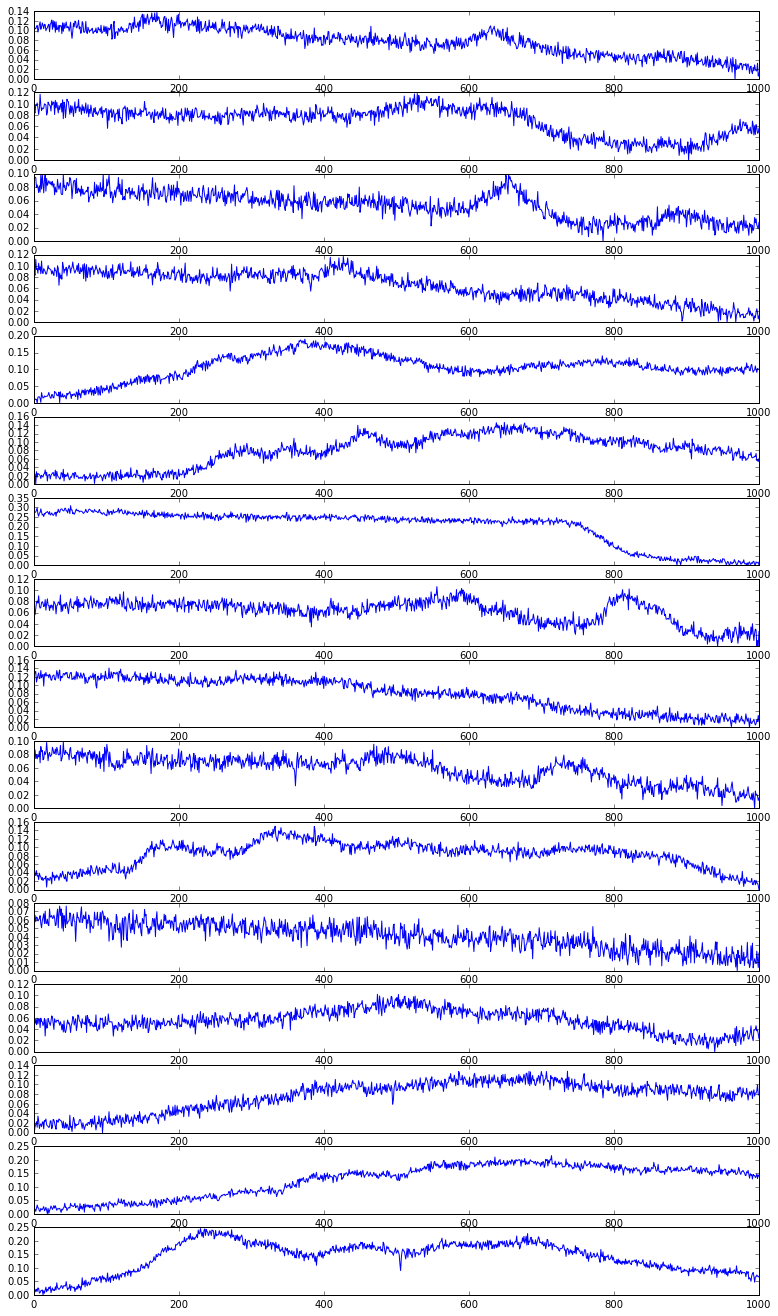

In [25]:
rows=len(cellsSignif[1])
cols=1
f2=gr.figure(figsize=(13,23))
ax=list()
gr.ioff()
for m in sc.arange(len(cellsSignif[1])):
    ax.append(f2.add_subplot(rows, cols, m+1))
    ax[m].plot(fMinData[cellsSignif[1][m]])


gr.ion(); gr.draw()
    

Graph all Ca traces and their normalized versions 

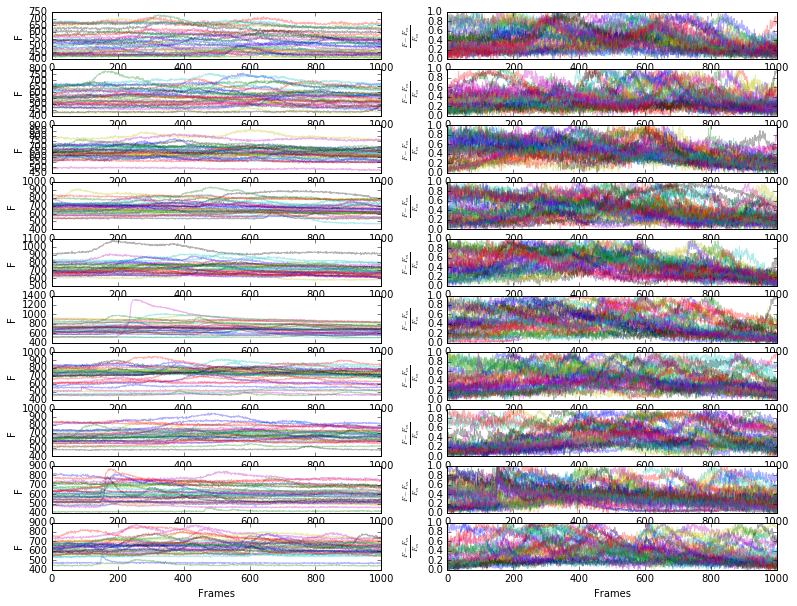

In [18]:
# Graficas exploratoria de todas las trazas     
#if 1:
figRaw=gr.figure(figsize=(13,10))
gr.ioff(); axRaw=list(); axFMin=list()
rows=10; cols=2
k= sc.int32(nCells/rows)
for m in sc.arange(rows):
    a= m*k; b= sc.minimum((m+1)*k, nCells)
    axRaw.append(figRaw.add_subplot(rows,cols,m*cols +1))
    axFMin.append(figRaw.add_subplot(rows,cols,m*cols +2))
    for n in sc.arange(a,b):
        axRaw[m].plot(rawData[n],alpha=0.3)
        axFMin[m].plot(fMaxMinData[n],alpha=0.3)
        axRaw[m].set_ylabel("F")
        axFMin[m].set_ylabel(r"$\frac{F-F_{m}}{F_{m}}$")
    if m>rows-2:
        axRaw[m].set_xlabel("Frames")
        axFMin[m].set_xlabel("Frames")

gr.ion(); gr.draw()

Quick quantification of areas under the curves for each cell

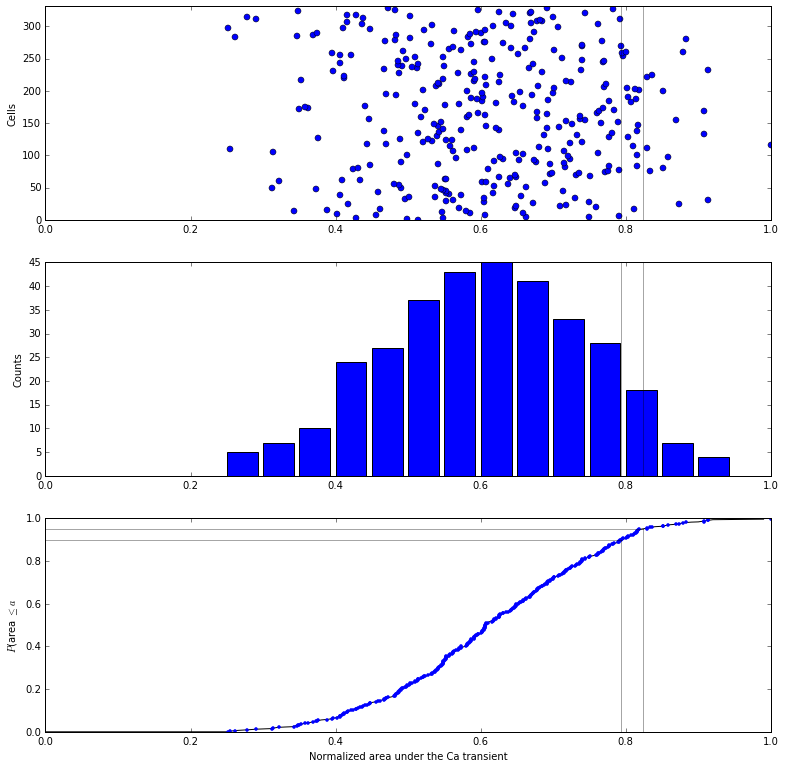

In [10]:
# Graphs of the total area distributions
rows=3; cols=1; barW=0.85*(binEdges[1]-binEdges[0])
f=gr.figure(figsize=(13,13))
gr.ioff()
ax=list()
for n in sc.arange(rows*cols):
    ax.append(f.add_subplot(rows,cols,n+1))

ax[0].plot(normAreas,sc.arange(nCells),'o')
ax[1].bar(left=binEdges[:-1],width=barW,height=counts)
ax[2].plot(areaArray, cdfArea(areaArray),'k', label='CDF')
ax[2].plot(sortedAreas, cdfArea(sortedAreas), 'b.', label='CDF')

if nThresh>1:
    for mm in sc.arange(nThresh):
        ax[2].plot([threshArea[mm], threshArea[mm]], [0,signif[mm]], 'k',  alpha=0.35, label='CDF')
        ax[2].plot([0, threshArea[mm]], [signif[mm],signif[mm]], 'k',  alpha=0.35, label='CDF')
        ax[1].plot([threshArea[mm], threshArea[mm]], [0,counts.max()], 'k',  alpha=0.35, label='CDF')
        ax[0].plot([threshArea[mm], threshArea[mm]], [0,nCells+1], 'k',  alpha=0.35, label='CDF')
else:
    ax[2].plot([threshArea[0], threshArea[0]], [0,signif[0]], 'k', alpha=0.35, label='CDF')

ax[0].set_ylabel("Cells")
ax[2].set_xlabel("Normalized area under the Ca transient")
ax[1].set_ylabel("Counts")
ax[2].set_ylabel(r"$P$(area $\leq a$")
ax[0].set_xlim(0,1)
ax[0].set_ylim(0,nCells+1)
ax[1].set_xlim(0,1)
ax[2].set_xlim(0,1)
gr.ion(); gr.draw()
